In [116]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
import os
sys.path.append(os.path.join('../src'))
from utils.definitions import ROOT_DIR
from data_loader import FarsightDataset, ToTensor
import data_loader
from utils.definitions import DATA_DIR, get_depth_dir, get_img_dir
import utils.definitions as defs
import visualize as viz
import model
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from trains import Task
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:

def train(epochs=2, verbose=False):
    """
    main training loop.
    """
    print('started')
    # create dataset
    ds = FarsightDataset(img_dir=get_img_dir(),
                         depth_dir=get_depth_dir(),
                         transform=ToTensor())
#     indices = torch.randperm(len(ds))[:2]
#     ds_sampler = torch.utils.data.SubsetRandomSampler(indices)
    minids = Subset(ds,[0,1])
    dataloader = DataLoader(minids,
                            shuffle=False,
                            batch_size=2,
                            num_workers=0)
    # TODO: fix weird float32 requirement in conv2d to work with uint8. Quantization?
    net = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.ReLU(),
        nn.Conv2d(6, 4, 3),
        nn.ReLU(),
        nn.ConvTranspose2d(4, 6, 3),
        nn.ReLU(),
        nn.ConvTranspose2d(6, 1, 5),
        nn.ReLU(),
        model.Squeeze()
    )
    net.to(device=defs.get_cuda())
    num_batches = len(dataloader)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters())
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            # get the inputs; data is a list of [input images, depth maps]
            inputs, gt_depths = data['image'], data['depth']
            optimizer.zero_grad()
            # print('input shape {}, type: {}'.format(inputs.size(), inputs.dtype))
            outputs = net(inputs)
            # print('out shape: {}, gt_shape: {}'.format(outputs.size(), gt_depths.size()))
            loss = criterion(outputs, gt_depths)
            print('loss: ',loss)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            if i % 5 == 4:
                print('[epoch %d, iter %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 5))
                # logger.report_scalar("loss", "loss",
                #                      iteration=(epoch * num_batches + i),
                #                      value=running_loss / 5)
                running_loss = 0.0
        if verbose or epoch == epochs-1:
            viz.show_batch({**data, 'pred': outputs.detach()})
            plt.title('epoch {}'.format(epoch))
            plt.show()
    print('Finished Training')

started
loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


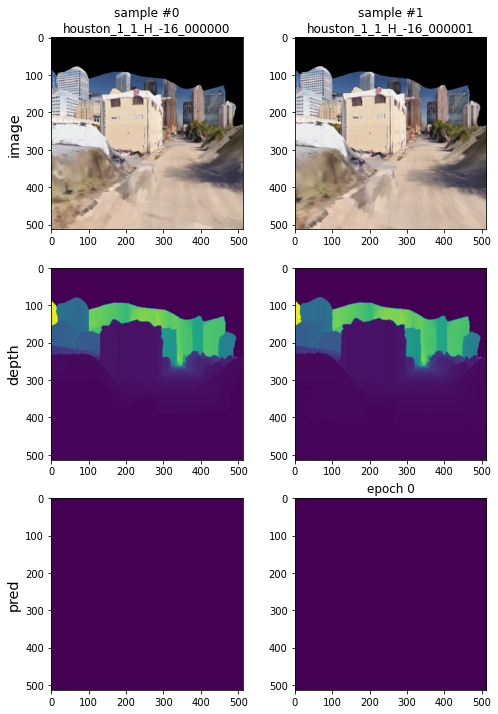

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


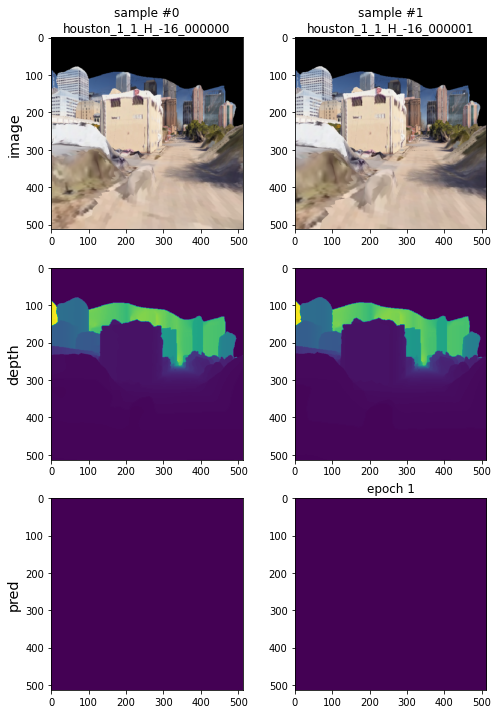

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


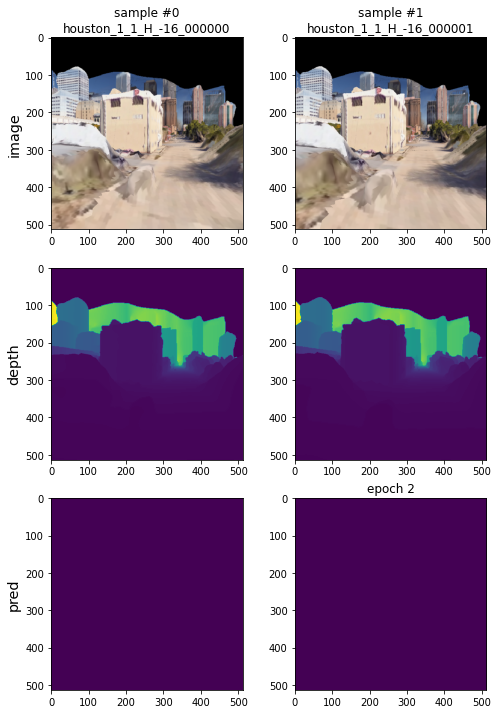

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


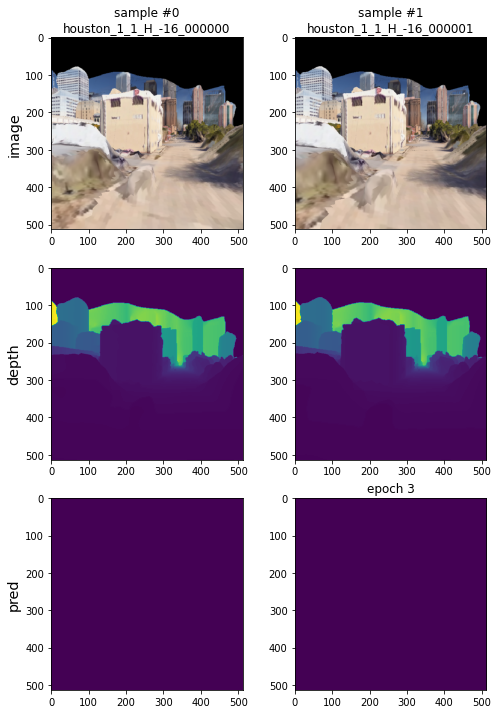

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


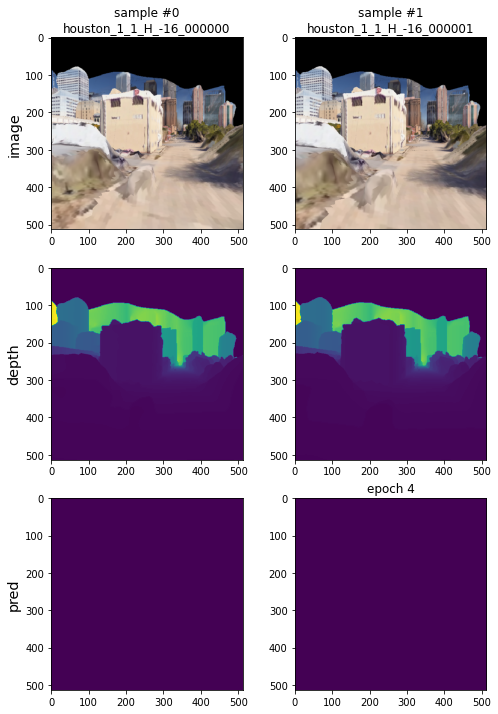

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


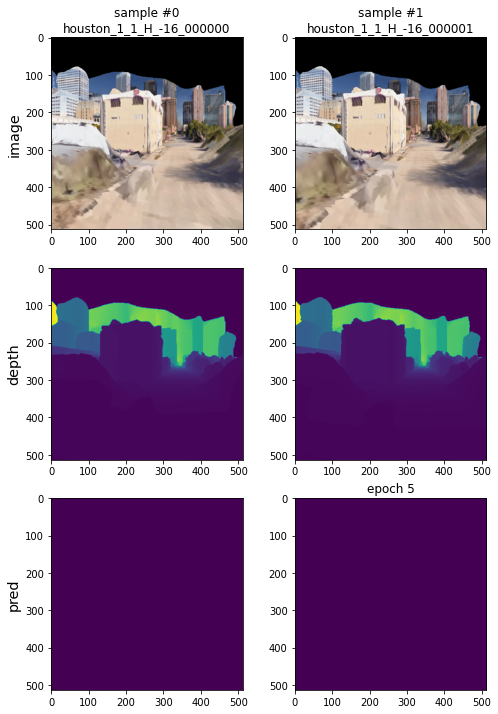

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


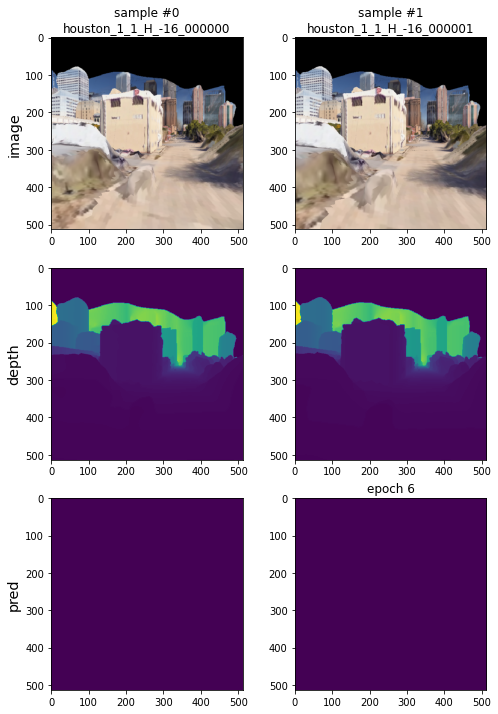

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


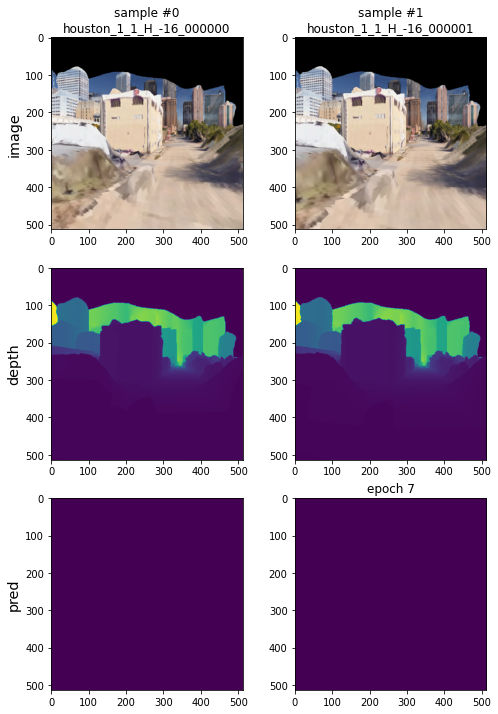

loss:  tensor(0.0412, grad_fn=<MseLossBackward>)
batch size:  2


KeyboardInterrupt: 

In [132]:
train(50,True)